In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [28]:
inspections = pd.read_pickle('/home/michael/chicagohealthinspections/data/inspectdata.pkl')
locations = pd.read_pickle('/home/michael/chicagohealthinspections/data/linkloc.pkl')
businesses = pd.read_pickle('/home/michael/chicagohealthinspections/data/businesses.pkl')
category = pd.read_pickle('/home/michael/chicagohealthinspections/data/categories.pkl')
#violations = pd.read_pickle('/home/michael/chicagohealthinspections/data/violations.pkl')

# 4.0 Data Exploration
## 4.1 Clean up inspection data
I converted fields into numeric for modeling and added number values for the string fields

In [29]:
inspections['license'] = np.where(inspections['Inspection Type'].str.contains('License'),1,0)
inspections = inspections[inspections['license']==0]

In [30]:
inspections['y'] = np.where(inspections['Results']=='Fail',1,0)
inspections['inspcount'] = inspections.groupby('LocId').cumcount() + 1

In [31]:
inspections['prevfails'] = inspections.groupby('LocId')[['y']].cumsum()
inspections['prevfails'] = inspections['prevfails'] - inspections['y']
inspections['failpct'] = inspections['prevfails'] / inspections['inspcount']

In [32]:
inspections['Risknbr'] = inspections['Risk'].str.slice(5,6)
inspections['Risknbr'] = inspections['Risknbr'].fillna(0)

In [33]:
inspections['complaint'] = np.where((inspections['Inspection Type'].str.contains('Complaint'))
                                    |(inspections['Inspection Type'].str.contains('Poisoning')),1,0)
inspections['reinspection'] = np.where(inspections['Inspection Type'].str.contains('nspection'),1,0)

In [34]:
inspections.groupby('Inspection Type')[['complaint','reinspection','y']].sum()

,complaint,reinspection,y
Inspection Type,,,
1315 license reinspection,0,1,1
ADDENDUM,0,0,0
CANVAS,0,0,0
CANVASS FOR RIB FEST,0,0,0
CANVASS RE INSPECTION OF CLOSE UP,0,0,0
CANVASS SCHOOL/SPECIAL EVENT,0,0,0
CANVASS SPECIAL EVENTS,0,0,0
CHANGED COURT DATE,0,0,0
Canvass,0,0,10263


In [36]:
simplemodel = pd.merge(inspections[['y','Inspection Type','Results',
                                    'LocId','inspcount','prevfails',
                                    'failpct','Risknbr','complaint','reinspection']],
                    locations[['LocId','id','PRI_NEIGH']],
                    how='inner')
simplemodel = pd.merge(simplemodel,
                    businesses[['id','price','rating','review_count']],
                    how='inner')
simplemodel['price'] = [x.count('$') for x in simplemodel['price']]
simplemodel = simplemodel.drop(['Inspection Type','Results','PRI_NEIGH','review_count','Risknbr'],1)
simplemodel.head()

,y,LocId,inspcount,prevfails,failpct,complaint,reinspection,id,price,rating
0,0,1,1,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0
1,0,1,2,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0
2,0,1,3,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0
3,1,1,4,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0
4,0,1,5,1,0.2,1,1,el-ranchito-restaurant-chicago-5,1,2.0


In [37]:
rf = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=2,
                           n_jobs=-1,
                           class_weight='balanced')

In [39]:
X_train = simplemodel.drop(['prevfails','id','LocId'],1).copy(deep=True)
target = X_train.pop('y')
rf.fit(X_train,target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [40]:
rf.feature_importances_

array([ 0.2353469 ,  0.24695502,  0.02165902,  0.22817497,  0.07305909,
        0.194805  ])

In [41]:
X_train.head()

,inspcount,failpct,complaint,reinspection,price,rating
0,1,0.0,1,0,1,2.0
1,2,0.0,1,0,1,2.0
2,3,0.0,1,0,1,2.0
3,4,0.0,1,0,1,2.0
4,5,0.2,1,1,1,2.0


In [14]:
rf.score(X_train,target)

0.60628908195451281

In [15]:
flaskmodeldict = {'model':rf,'features':['inspcount', 'failpct', 'reinspection', 'price', 'rating']}

In [16]:
pickle.dump(flaskmodeldict,open('/home/michael/chicagohealthinspections/flask/pkl_rfmodel.p','wb'))

## 4.2 Graphing Exploration
graphs to show the relative effects of different features

KeyError: 'the label [prevfails] is not in the [columns]'

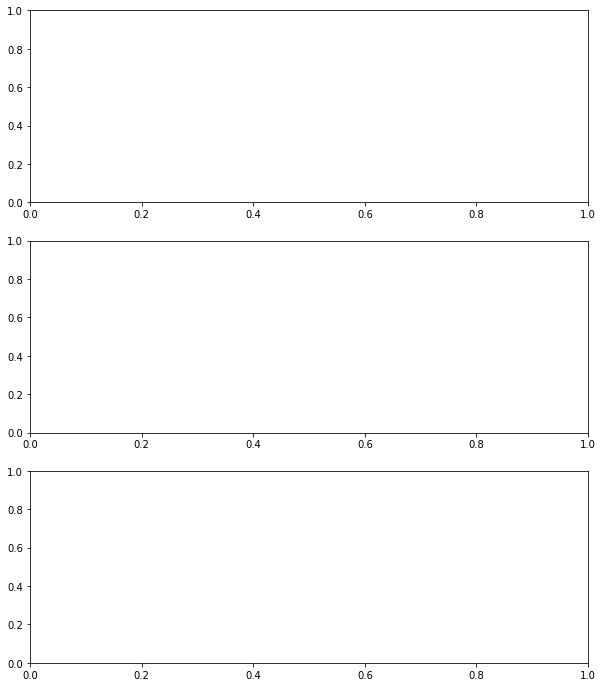

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'prevfails'], bins=8, range=(0,8))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'prevfails'], bins=8, range=(0,8))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'failpct'], bins=5, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'failpct'], bins=5, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'inspcount'], bins=20, range=(0,21))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'inspcount'], bins=20, range=(0,21))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'reinspection'], bins=2, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'reinspection'], bins=2, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'complaint'], bins=2, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'complaint'], bins=2, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'rating'], bins=8, range=(1,5))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'rating'], bins=8, range=(1,5))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'price'], bins=4, range=(0,5))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'price'], bins=4, range=(0,5))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

## 4.3 Categories 
So first I pulled in categories and did a random forest for important features for my target y

In [ ]:
category.head()

In [18]:
topcats = category.groupby('alias',as_index=False)[['id']].count().sort_values('id',ascending=False).head(25)
catlist = [x for x in topcats['alias']]
catdummy = category.copy(deep=True)
catdummy['cleancat'] = np.where(catdummy['alias'].isin(catlist),catdummy['alias'],'other')
dummys = pd.get_dummies(catdummy['cleancat'])
catdummy = catdummy.merge(dummys, how ='inner',right_index=True,left_index=True)
catdummy = catdummy.drop(['alias','title','catid','cleancat'],axis=1)

catdumcol = catdummy.columns
catdummy = catdummy.groupby('id',as_index=False)[catdumcol].sum()
catdummy.head()

,id,bakeries,bars,beer_and_wine,breakfast_brunch,burgers,cafes,chicken_wings,childcare,chinese,...,newamerican,other,pizza,salad,sandwiches,seafood,sportsbars,sushi,thai,tradamerican
0,1-chop-suey-chicago,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1000-liquors-chicago-2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1048-sky-lounge-wrigley-rooftop-chicago-4,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,10pin-bowling-lounge-chicago,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
4,11-degrees-north-chicago,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [19]:
catloc = locations[['LocId','id']].copy(deep=True)
catloc = catloc.merge(catdummy, how='inner')

In [20]:
catinsp = pd.merge(inspections[['y','LocId']],catloc)

In [21]:
catrf = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=5,
                           n_jobs=-1,
                           class_weight='balanced')

In [22]:
X_train_cat = catinsp.drop(['LocId','id'],1)
target_cat = X_train_cat.pop('y')
catrf.fit(X_train_cat,target_cat)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [23]:
results = np.column_stack((X_train_cat.columns,catrf.feature_importances_))
results = results[results[:,1].argsort()][::-1]
catfeats = results[1:6,0].tolist()
catfeats.append('id')
results

array([['other', 0.14896093639483488],
       ['breakfast_brunch', 0.058830746538760914],
       ['sandwiches', 0.05508692838540342],
       ['burgers', 0.052744192388757376],
       ['pizza', 0.049638460742354715],
       ['mexican', 0.04649078974761607],
       ['newamerican', 0.045478569839395806],
       ['salad', 0.044510713963615785],
       ['hotdogs', 0.04448255265364926],
       ['italian', 0.04234682073223447],
       ['tradamerican', 0.04065340711715801],
       ['coffee', 0.037578515899391624],
       ['seafood', 0.0367189600729567],
       ['chicken_wings', 0.03368697680693383],
       ['cafes', 0.033523246103225025],
       ['bars', 0.029884790159254934],
       ['bakeries', 0.027231768230956178],
       ['sportsbars', 0.025203006931573693],
       ['icecream', 0.023954098941374024],
       ['grocery', 0.023692839478437453],
       ['beer_and_wine', 0.023414583064777353],
       ['chinese', 0.02191393378449271],
       ['childcare', 0.018288388953744773],
       ['conveni

## 4.4 Combine Categories with other features

In [46]:
modelcat = pd.merge(simplemodel,catdummy[catfeats],how='inner')
modelcat.head()

,y,LocId,inspcount,prevfails,failpct,complaint,reinspection,id,price,rating,breakfast_brunch,sandwiches,burgers,pizza,mexican
0,0,1,1,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0,0,0,0,1,1
1,0,1,2,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0,0,0,0,1,1
2,0,1,3,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0,0,0,0,1,1
3,1,1,4,0,0.0,1,0,el-ranchito-restaurant-chicago-5,1,2.0,0,0,0,1,1
4,0,1,5,1,0.2,1,1,el-ranchito-restaurant-chicago-5,1,2.0,0,0,0,1,1


In [48]:
rff = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=4,
                           n_jobs=-1,
                           class_weight='balanced')

In [49]:
test = modelcat.drop(['id','LocId'],1)
X_train_cat = test.copy(deep=True)
target_cat = X_train_cat.pop('y')
rff.fit(X_train_cat,target_cat)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [53]:
results = np.column_stack((X_train_cat.columns,rff.feature_importances_))
results = results[results[:,1].argsort()][::-1]
cols = results[:,0].tolist()
cols.insert(0, 'y')
cols.insert(0, 'id')
cols.insert(0, 'LocId')

In [54]:
modelcat = modelcat[cols]
modelcat.head()

,LocId,id,y,rating,inspcount,reinspection,failpct,price,prevfails,breakfast_brunch,pizza,mexican,burgers,complaint,sandwiches
0,1,el-ranchito-restaurant-chicago-5,0,2.0,1,0,0.0,1,0,0,1,1,0,1,0
1,1,el-ranchito-restaurant-chicago-5,0,2.0,2,0,0.0,1,0,0,1,1,0,1,0
2,1,el-ranchito-restaurant-chicago-5,0,2.0,3,0,0.0,1,0,0,1,1,0,1,0
3,1,el-ranchito-restaurant-chicago-5,1,2.0,4,0,0.0,1,0,0,1,1,0,1,0
4,1,el-ranchito-restaurant-chicago-5,0,2.0,5,1,0.2,1,1,0,1,1,0,1,0


In [55]:
modelcat.to_pickle('/home/michael/chicagohealthinspections/data/model.pkl')